## Import Libraries

In [1]:
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Helper function 
This helper function is used to plot the image , with a given title has a default value of **_"Image"_** , we also pass to the function color map argument that it has default value of **_gray_**


In [2]:
def show_image(image , title = "Image" , color_map = "gray") :
    plt.imshow(image , cmap= color_map)
    plt.title(title)
    plt.show

### Read the test image

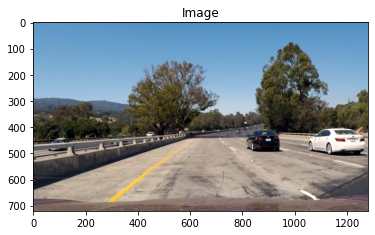

In [3]:
test_image = plt.imread("test_images/test1.jpg")
show_image(test_image)

### Change the color space 
we here change the color space of the image from BGR to RGB to show the real color space of the image

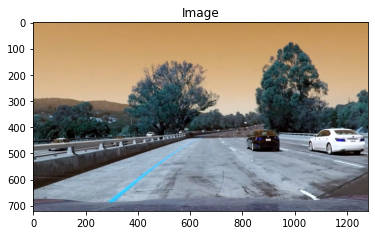

In [4]:
RGB_test_image = cv.cvtColor(test_image , cv.COLOR_BGR2RGB)
show_image(RGB_test_image)

### Image Dimensions

In [5]:
print("Image Shape" , RGB_test_image.shape)
image_width = RGB_test_image.shape[1]
image_height = RGB_test_image.shape[0]
print("Image width" , image_width)
print("Image height" , image_height)

Image Shape (720, 1280, 3)
Image width 1280
Image height 720


### Change the color space 
we here change the color space of the image from RGB to grayscale

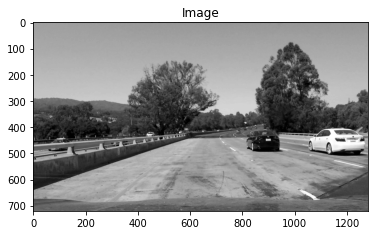

In [6]:
gray_test_image = cv.cvtColor(RGB_test_image , cv.COLOR_RGB2GRAY)
show_image(gray_test_image)

### Change color space
we here change the color space of the image from **_RGB_** into **_HLS_** color space as this color space would be very useful when we deal with image that has sunlight (part of it or whole of it), and that would make a very high noise and a cause of that that we will not determine any more the lane lines

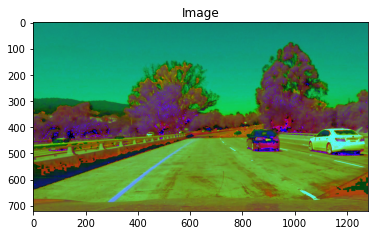

In [7]:
hls_test_image = cv.cvtColor(RGB_test_image , cv.COLOR_RGB2HLS)
show_image(hls_test_image)

### Split HLS into Channels
we here divide the HLS image into three channels as we desire to deal with S channel as it provide clear lane lines among the other channels

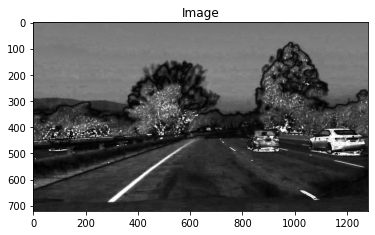

In [8]:
h , l , s = cv.split(hls_test_image)
show_image(s)


### Edge Detection
We will use **_Canny edge_** detection 

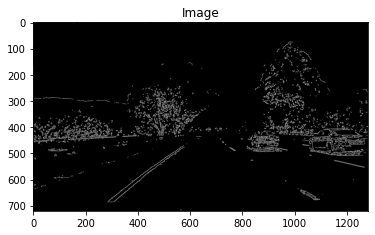

In [9]:
canny_test_image = cv.Canny(s , 200 ,255)
show_image(canny_test_image)

## Region Of Intereset
We will crop part of the photo where we are have more interest in this region to determine the lane lines , the steps are the following we make a black image with all zeros , then we have the vertices of ploy to draw on the black image , then making masking using python function `cv.bitwise_and()`

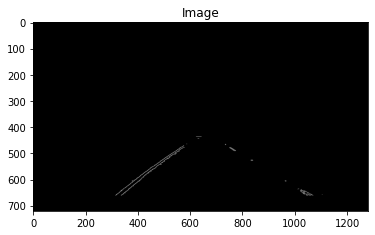

In [10]:
def region_of_intereset(image , vertices):
    blank = np.zeros_like(image)
    cv.fillPoly(blank , vertices , color = 255)
    cropped_region = cv.bitwise_and(image , blank)
    return cropped_region
vertices_of_region_of_interest = [(100 , 660) , (image_width / 2 , image_height / 2 + 65) , (1200 , 660)]
cropped_test_image = region_of_intereset(canny_test_image , np.array([vertices_of_region_of_interest] , np.int32))
show_image(cropped_test_image)

### Hough Transform & Optimization
In this section we use Hough transform to find lane lines then averaging the lines to have 2 smooth lines contouring the lane.

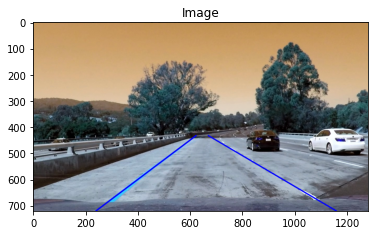

In [11]:
def make_coordinates (image, line_parameters):
    slope, intercept = line_parameters
    height= image.shape[0]
    y1=height
    y2=int(y1*(3/5))
    x1=int((y1-intercept)/slope)
    x2=int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

def average_slope_intercept(image,lines):
    left_fit=[]
    right_fit=[]
    for line in lines:
        x1,y1,x2,y2=line.reshape(4)
        parameters=np.polyfit((x1,x2),(y1,y2),1)
        slope=parameters[0]
        intercept=parameters[1]
        if slope<0:
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
    left_fit_average=np.average(left_fit,axis=0)     
    right_fit_average=np.average(right_fit,axis=0)
    left_line= make_coordinates(image,left_fit_average)
    right_line= make_coordinates(image,right_fit_average)
    return np.array([left_line, right_line])

def display_lines(image, lines):
    line_image= np.zeros_like(image)
    if lines is not None :
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4)
            cv.line(line_image,(x1,y1),(x2,y2),(0,0,255),4)
    return line_image

hough_lines = cv.HoughLinesP(cropped_test_image , 1, np.pi / 180 , 20, minLineLength = 7 , maxLineGap = 1)
averaged_lines=average_slope_intercept(RGB_test_image,hough_lines)
line_image=display_lines(RGB_test_image,averaged_lines)
if averaged_lines is not None:
        for line in averaged_lines :
            x1 ,y1 ,x2 ,y2 = line.reshape(4)
            cv.line(RGB_test_image , (x1 , y1) , (x2 ,y2) , (0 , 0 , 255) , thickness = 4)
show_image(RGB_test_image)

### Processing on video frames
We define a function that performs all the previous operations on a given input image to be applied on video frames.

In [12]:
def frame_process(test_image):
    RGB_test_image = np.copy(test_image)
    image_width = RGB_test_image.shape[1]
    image_height = RGB_test_image.shape[0]
    hls_test_image = cv.cvtColor(RGB_test_image , cv.COLOR_RGB2HLS)
    h , l , s = cv.split(hls_test_image)
    canny_test_image = cv.Canny(s , 200 , 255)
    vertices_of_region_of_interest = [(100 , 660) , (image_width / 2 , image_height / 2 + 65) , (1200 , 660)]
    cropped_test_image = region_of_intereset(canny_test_image , np.array([vertices_of_region_of_interest] , np.int32))
    hough_lines = cv.HoughLinesP(cropped_test_image , 1 , np.pi / 180 , 20 , minLineLength = 7 , maxLineGap = 1)
    
    averaged_lines=average_slope_intercept(RGB_test_image,hough_lines)
    line_image=display_lines(RGB_test_image,averaged_lines)
    if averaged_lines is not None:
        for line in averaged_lines :
            x1 ,y1 ,x2 ,y2 = line.reshape(4)
            cv.line(RGB_test_image , (x1 , y1) , (x2 ,y2) , (0 , 0 , 255) , thickness = 4)
    return RGB_test_image

## Testing the previous function on the test images

#### Test Image 2

In [13]:
test_image2 = cv.imread("C:\\Users\\shereen\\Documents\\GitHub\\Simple-Perception-Stack-for-Self-Driving-Cars\\Project_data\\test_images\\test2.jpg")
test_image2 = cv.cvtColor(test_image2, cv.COLOR_BGR2RGB)
test_image2_processed = frame_process(test_image2)

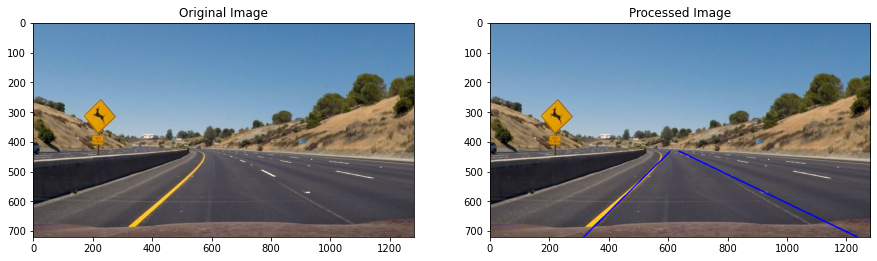

In [14]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
show_image(test_image2, 'Original Image')
fig.add_subplot(1,2,2)
show_image(test_image2_processed, 'Processed Image')

#### Test Image 3

In [15]:
test_image3 = cv.imread("test_images/test3.jpg")
test_image3 = cv.cvtColor(test_image3, cv.COLOR_BGR2RGB)
test_image3_processed = frame_process(test_image3)

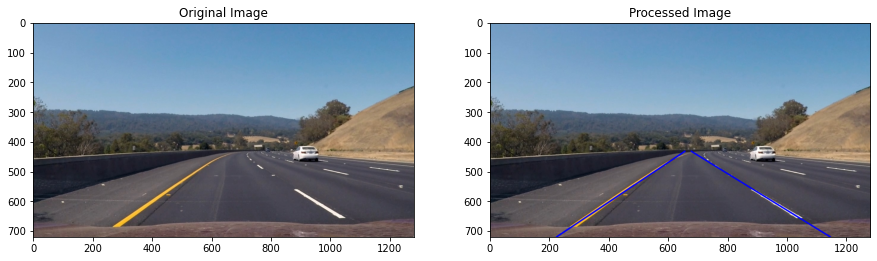

In [16]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
show_image(test_image3, 'Original Image')
fig.add_subplot(1,2,2)
show_image(test_image3_processed, 'Processed Image')

#### Test Image 4

In [17]:
test_image4 = cv.imread("test_images/test4.jpg")
test_image4 = cv.cvtColor(test_image4, cv.COLOR_BGR2RGB)
test_image4_processed = frame_process(test_image4)

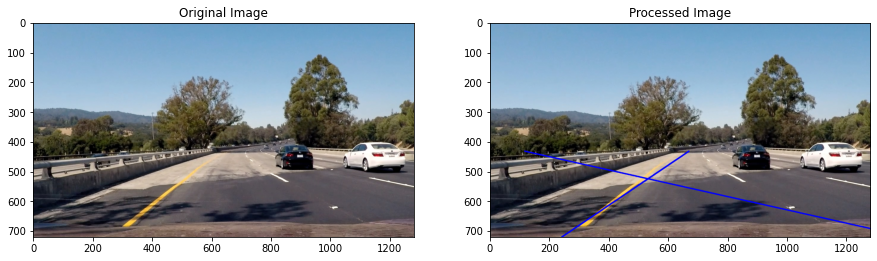

In [18]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
show_image(test_image4, 'Original Image')
fig.add_subplot(1,2,2)
show_image(test_image4_processed, 'Processed Image')

#### Test Image 5

In [19]:
test_image5 = cv.imread("test_images/test5.jpg")
test_image5 = cv.cvtColor(test_image5, cv.COLOR_BGR2RGB)
test_image5_processed = frame_process(test_image5)

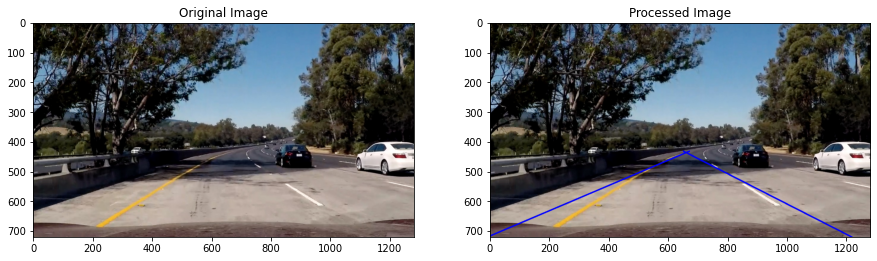

In [20]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
show_image(test_image5, 'Original Image')
fig.add_subplot(1,2,2)
show_image(test_image5_processed, 'Processed Image')

#### Test Image 6

In [21]:
test_image6 = cv.imread("test_images/test6.jpg")
test_image6 = cv.cvtColor(test_image6, cv.COLOR_BGR2RGB)
test_image6_processed = frame_process(test_image6)

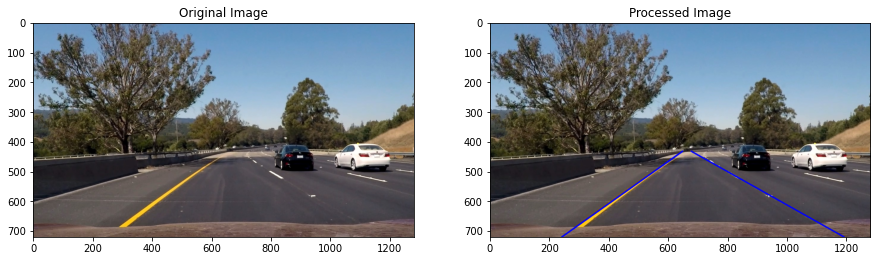

In [22]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
show_image(test_image6, 'Original Image')
fig.add_subplot(1,2,2)
show_image(test_image6_processed, 'Processed Image')

#### Test Image 7 (straight lines 1)

In [23]:
test_image7 = cv.imread("test_images/straight_lines1.jpg")
test_image7 = cv.cvtColor(test_image7, cv.COLOR_BGR2RGB)
test_image7_processed = frame_process(test_image7)

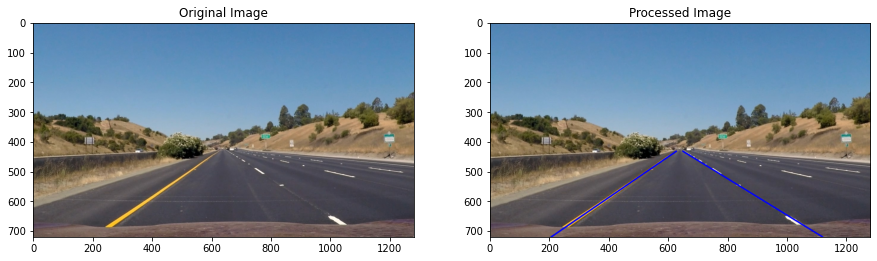

In [24]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
show_image(test_image7, 'Original Image')
fig.add_subplot(1,2,2)
show_image(test_image7_processed, 'Processed Image')

#### Test Image 8 (straight lines 2)

In [25]:
test_image8 = cv.imread("test_images/straight_lines2.jpg")
test_image8 = cv.cvtColor(test_image8, cv.COLOR_BGR2RGB)
test_image8_processed = frame_process(test_image8)

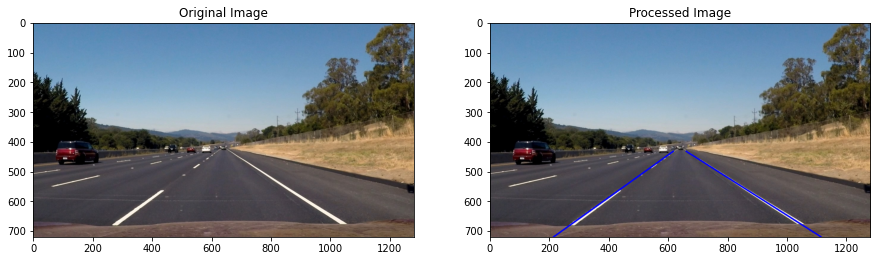

In [26]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2,1)
show_image(test_image8, 'Original Image')
fig.add_subplot(1,2,2)
show_image(test_image8_processed, 'Processed Image')

In [27]:
def get_radius_of_curvature(xm_per_pix, ym_per_pix):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    radius_of_curvature = min(left_curverad, right_curverad)
    
    return radius_of_curvature
def get_vehicle_position(xm_per_pix, ym_per_pix):
    car_center = ((right_fitx[-1] * xm_per_pix) - (left_fitx[-1] * xm_per_pix))/2
    actual_center = 3.7/2
    difference = abs(car_center - actual_center)
    
    if (left_fitx[-1] > (1280 - right_fitx[-1])):
        direction = 'left'
    elif (left_fitx[-1] < (1280 - right_fitx[-1])):
        direction = 'right'
    else:
        direction = 'center'

    return difference, direction